In [1]:
import os
import cv2
import tifffile
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

train_csv = pd.read_csv('../data/train.csv')
def get_image_mask(id_):
    image = tifffile.imread('../data/train/{}.tiff'.format(id_))
    mask_cod  = train_csv.loc[train_csv['id'] == id_]['encoding'].values[0]
    
#     if id_ in ['e79de561c', '095bf7a1f', '1e2425f28', '54f2eec69']:
    if image.ndim == 5:
        image = image[0,0,:,:,:]
        image = np.transpose(image, (1,2,0))
    
    mask = np.zeros((image.shape[0]*image.shape[1]), dtype=np.uint8)
    
    rle_mask = mask_cod.split()
    positions = map(int, rle_mask[::2])
    lengths = map(int, rle_mask[1::2])
    for pos, le in zip(positions, lengths):
        mask[pos-1:pos+le-1] = 1
   
    mask = mask.reshape((image.shape[1], image.shape[0]))

    return image, mask.T

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [2]:
data_count = 0
target_root = "E:/HuBMAP_data/"
img_root = target_root + "img/"
mask_root = target_root + "mask/"
if not os.path.exists(target_root):
    os.makedirs(target_root)
if not os.path.exists(img_root):
    os.makedirs(img_root)
if not os.path.exists(mask_root):
    os.makedirs(mask_root)

count_background = 0
count_nomean_background = 0
for _id in train_csv['id']:
    print("正在处理 ",_id)
    image, mask = get_image_mask(_id)
    print(image.shape, mask.shape)

    need_shift = {
        "e79de561c":[5, 10],
        "095bf7a1f":[20, 15],
        "54f2eec69":[-10, -15]
    }
    if _id in need_shift:
        print(_id, "需要修正mask")
        shift_horizontal, shift_vertical = need_shift[_id]
        h, w = mask.shape
        mask_temp = np.zeros_like(mask)
        mask_temp[max(0, -shift_vertical):min(h, h-shift_vertical), max(0, -shift_horizontal):min(w, w-shift_horizontal)] = \
            mask[max(0, shift_vertical):min(h, h+shift_vertical), max(0, shift_horizontal):min(w, w+shift_horizontal)]
        mask = mask_temp.copy()
        del mask_temp

    mask_re = cv2.resize(mask, (1024, 1024))
    label_img = label(mask_re, connectivity = mask.ndim)
    props = regionprops(label_img)
    print("mask数量", len(props))

    mask = mask*255
    window_size = 0
    for p in props:
        bbox = list(p.bbox)
        bbox[0] = int(bbox[0]* mask.shape[0]/1024)
        bbox[2] = int(bbox[2]* mask.shape[0]/1024)
        bbox[1] = int(bbox[1]* mask.shape[1]/1024)
        bbox[3] = int(bbox[3] * mask.shape[1]/1024)
        
        if bbox[2] - bbox[1] < 190 or bbox[2] - bbox[1] < 190:
            continue
        
        window_size += 3*(((bbox[2]-bbox[0]) + (bbox[3]-bbox[1]))/2)

        random_scalors = [1.5, 10]
        for random_scalor in random_scalors:
            margin = int(((bbox[2]-bbox[0]) + (bbox[3]-bbox[1]))//random_scalor)
            cv2.imwrite(img_root + "{}_img.png".format(data_count), image[max(bbox[0]-margin, 0):bbox[2]+margin, max(bbox[1]-margin, 0):bbox[3]+margin])
            cv2.imwrite(mask_root + "{}_mask.png".format(data_count), mask[max(bbox[0]-margin, 0):bbox[2]+margin, max(bbox[1]-margin, 0):bbox[3]+margin])
            data_count += 1

    window_size = int(window_size/len(props))
    mesh_grid = make_grid(image.shape[:2], window=window_size, min_overlap = int(window_size//4))
    print("mesh_grid数量", len(mesh_grid))
    for cell in mesh_grid:
        temp = image[cell[0]:cell[1], cell[2]:cell[3]].mean((0, 1))
        if sum(abs(temp - temp.mean())) < 12:
            #过滤掉很多无用的背景
            count_nomean_background += 1
            if count_nomean_background % 15:
                continue
        temp = mask[cell[0]:cell[1], cell[2]:cell[3]]
        flg = (np.sum(temp)/255)/(temp.shape[0]*temp.shape[1]) > 0.031
        if flg:
            cv2.imwrite(img_root + "{}_img.png".format(data_count), image[cell[0]:cell[1], cell[2]:cell[3]])
            cv2.imwrite(mask_root + "{}_mask.png".format(data_count), mask[cell[0]:cell[1], cell[2]:cell[3]])
            data_count += 1
        else:
            if count_background%3==0:
                cv2.imwrite(img_root + "{}_img.png".format(data_count), image[cell[0]:cell[1], cell[2]:cell[3]])
                data_count += 1
            count_background += 1
    print("-----------------")
print("Done~~~")

正在处理  2f6ecfcdf
(31278, 25794, 3) (31278, 25794)
mask数量 157
mesh_grid数量 13104
-----------------
正在处理  aaa6a05cc
(18484, 13013, 3) (18484, 13013)
mask数量 93
mesh_grid数量 1924
-----------------
正在处理  cb2d976f4
(34940, 49548, 3) (34940, 49548)
mask数量 299
mesh_grid数量 6930
-----------------
正在处理  0486052bb
(25784, 34937, 3) (25784, 34937)
mask数量 121
mesh_grid数量 8910
-----------------
正在处理  e79de561c
(16180, 27020, 3) (16180, 27020)
e79de561c 需要修正mask
mask数量 191
mesh_grid数量 8906
-----------------
正在处理  095bf7a1f
(38160, 39000, 3) (38160, 39000)
095bf7a1f 需要修正mask
mask数量 323
mesh_grid数量 4032
-----------------
正在处理  54f2eec69
(30440, 22240, 3) (30440, 22240)
54f2eec69 需要修正mask
mask数量 134
mesh_grid数量 4720
-----------------
正在处理  1e2425f28
(26780, 32220, 3) (26780, 32220)
mask数量 179
mesh_grid数量 5070
-----------------
Done~~~


In [2]:
data_count = 0
target_root = "E:/HuBMAP_data/"
img_root = target_root + "img/"
mask_root = target_root + "mask/"
if not os.path.exists(target_root):
    os.makedirs(target_root)
if not os.path.exists(img_root):
    os.makedirs(img_root)
if not os.path.exists(mask_root):
    os.makedirs(mask_root)

count_background = 0

In [3]:
_id = "e79de561c"
print("正在处理 ",_id)
image, mask = get_image_mask(_id)
print(image.shape, mask.shape)

need_shift = {
    "e79de561c":[10, 5],
    "095bf7a1f":[20, 15],
    "54f2eec69":[-10, -15]
}
if _id in need_shift:
    print(_id, "需要修正mask")
    shift_horizontal, shift_vertical = need_shift[_id]
    h, w = mask.shape
    mask_temp = np.zeros_like(mask)
    mask_temp[max(0, -shift_vertical):min(h, h-shift_vertical), max(0, -shift_horizontal):min(w, w-shift_horizontal)] = \
        mask[max(0, shift_vertical):min(h, h+shift_vertical), max(0, shift_horizontal):min(w, w+shift_horizontal)]
    mask = mask_temp.copy()
    del mask_temp

mask_re = cv2.resize(mask, (1024, 1024))
label_img = label(mask_re, connectivity = mask.ndim)
props = regionprops(label_img)
print("mask数量", len(props))

mask = mask*255
window_size = 0
for p in props:
    bbox = list(p.bbox)
    bbox[0] = int(bbox[0]* mask.shape[0]/1024)
    bbox[2] = int(bbox[2]* mask.shape[0]/1024)
    bbox[1] = int(bbox[1]* mask.shape[1]/1024)
    bbox[3] = int(bbox[3] * mask.shape[1]/1024)
    window_size += 3*(((bbox[2]-bbox[0]) + (bbox[3]-bbox[1]))/2)

    random_scalors = [1.5, 10]
    for random_scalor in random_scalors:
        margin = int(((bbox[2]-bbox[0]) + (bbox[3]-bbox[1]))//random_scalor)
        cv2.imwrite(img_root + "{}_img.png".format(data_count), image[max(bbox[0]-margin, 0):bbox[2]+margin, max(bbox[1]-margin, 0):bbox[3]+margin])
        cv2.imwrite(mask_root + "{}_mask.png".format(data_count), mask[max(bbox[0]-margin, 0):bbox[2]+margin, max(bbox[1]-margin, 0):bbox[3]+margin])
        data_count += 1

window_size = int(window_size/len(props))
mesh_grid = make_grid(image.shape[:2], window=window_size, min_overlap = int(window_size//4))
print("mesh_grid数量", len(mesh_grid))
for cell in mesh_grid:
    temp = mask[cell[0]:cell[1], cell[2]:cell[3]]
    flg = (np.sum(temp)/255)/(temp.shape[0]*temp.shape[1]) > 0.031
    if flg and count_background%3==0:
        cv2.imwrite(img_root + "{}_img.png".format(data_count), image[cell[0]:cell[1], cell[2]:cell[3]])
        data_count += 1
    if flg:
        cv2.imwrite(mask_root + "{}_mask.png".format(data_count), mask[cell[0]:cell[1], cell[2]:cell[3]])
        count_background += 1
print("-----------------")

正在处理  e79de561c
(16180, 27020, 3) (16180, 27020)
e79de561c 需要修正mask
mask数量 191
mesh_grid数量 792
-----------------


In [18]:
cell = mesh_grid[-100]
temp = mask[cell[0]:cell[1], cell[2]:cell[3]]
print((np.sum(temp)/255)/(temp.shape[0]*temp.shape[1]))

0.24666089965397925


(1020, 1020)


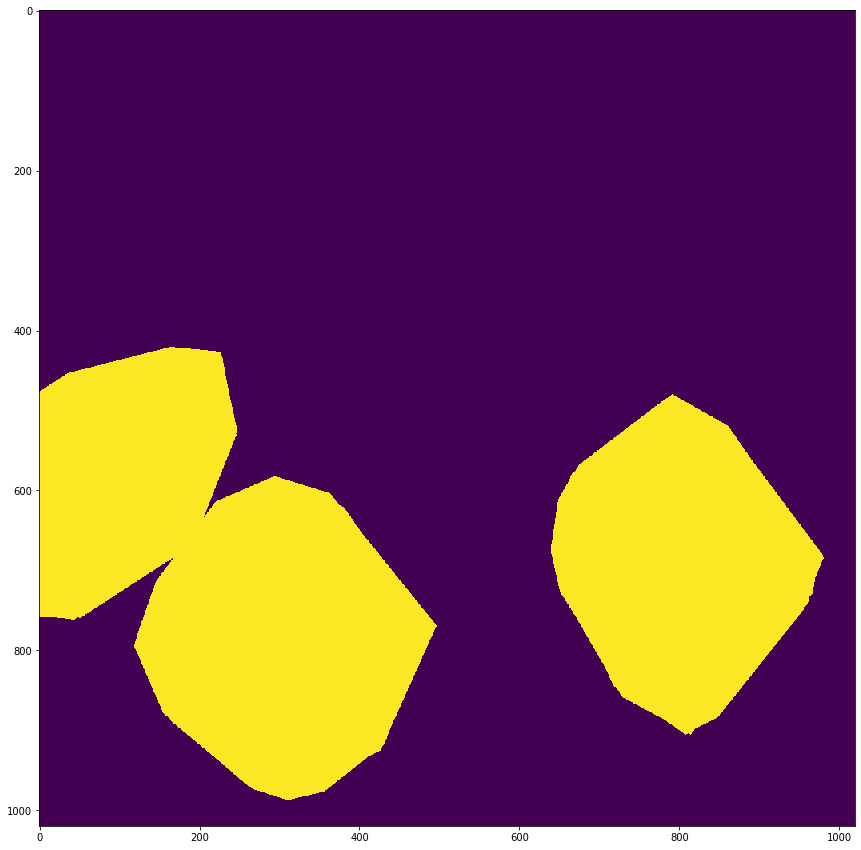

In [19]:
print(mask[cell[0]:cell[1], cell[2]:cell[3]].shape)
plt.figure(figsize=(15,15))
plt.imshow(mask[cell[0]:cell[1], cell[2]:cell[3]])

In [3]:
for _id in train_csv['id']:
    print(_id)

2f6ecfcdf
aaa6a05cc
cb2d976f4
0486052bb
e79de561c
095bf7a1f
54f2eec69
1e2425f28


In [15]:
cv2.imwrite(img_root + "{}_img.png".format(10000), image[max(bbox[0]-margin, 0):bbox[2]+margin, max(bbox[1]-margin, 0):bbox[3]+margin])

True

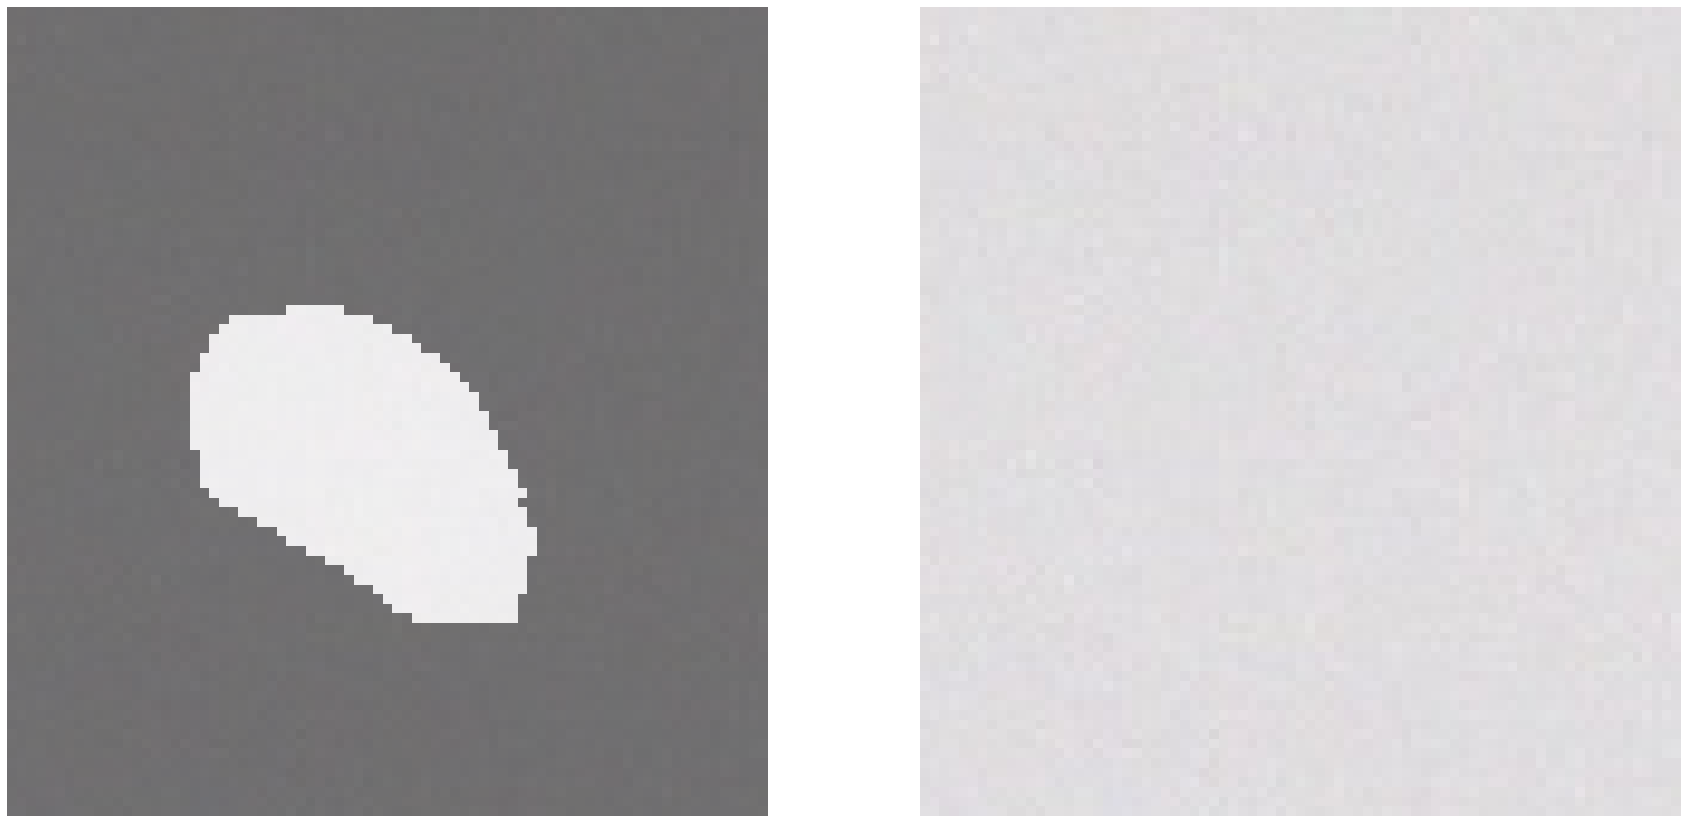

In [14]:
bbox = [18235, 23577, 18265, 23602]
# bbox[0] = int(bbox[0]* mask.shape[0]/1024)
# bbox[2] = int(bbox[2]* mask.shape[0]/1024)
# bbox[1] = int(bbox[1]* mask.shape[1]/1024)
# bbox[3] = int(bbox[3] * mask.shape[1]/1024)
plt.figure(figsize=(30,30))
plt.subplot("121")
plt.axis('off')
margin = int(((bbox[2]-bbox[0]) + (bbox[3]-bbox[1]))//2)
plt.imshow(image[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin])
plt.imshow(mask[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin],alpha=0.5, cmap='gray')
plt.subplot("122")
plt.axis('off')
plt.imshow(image[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin])
plt.show()

In [8]:

mask[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin].shape

(0, 0)

In [4]:
print(_id, "需要修正mask")
shift_horizontal, shift_vertical = need_shift[_id]
h, w = mask.shape
mask_temp = np.zeros_like(mask)
mask_temp[max(0, -shift_vertical):min(h, h-shift_vertical), max(0, -shift_horizontal):min(w, w-shift_horizontal)] = \
    mask[max(0, shift_vertical):min(h, h+shift_vertical), max(0, shift_horizontal):min(w, w+shift_horizontal)]
mask = mask_temp.copy()
# del mask_temp
bbox = list(props[0].bbox)
bbox[0] = int(bbox[0]* mask.shape[0]/1024)
bbox[2] = int(bbox[2]* mask.shape[0]/1024)
bbox[1] = int(bbox[1]* mask.shape[1]/1024)
bbox[3] = int(bbox[3] * mask.shape[1]/1024)
plt.figure(figsize=(30,30))
plt.subplot("121")
plt.axis('off')
margin = int(((bbox[2]-bbox[0]) + (bbox[3]-bbox[1]))//10)
plt.imshow(image[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin])
plt.imshow(mask[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin],alpha=0.5, cmap='gray')
plt.subplot("122")
plt.axis('off')
plt.imshow(image[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin])
plt.show()

2f6ecfcdf 需要修正mask


KeyError: '2f6ecfcdf'

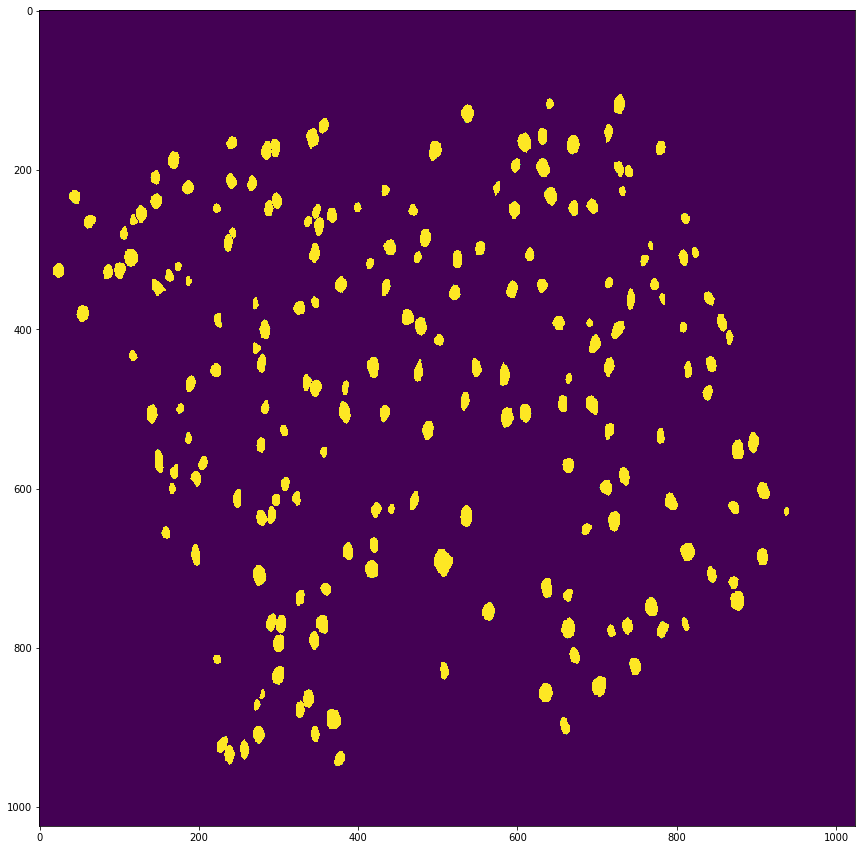

In [4]:
mask_re = cv2.resize(mask, (1024, 1024))
plt.figure(figsize=(15,15))
plt.imshow(mask_re)

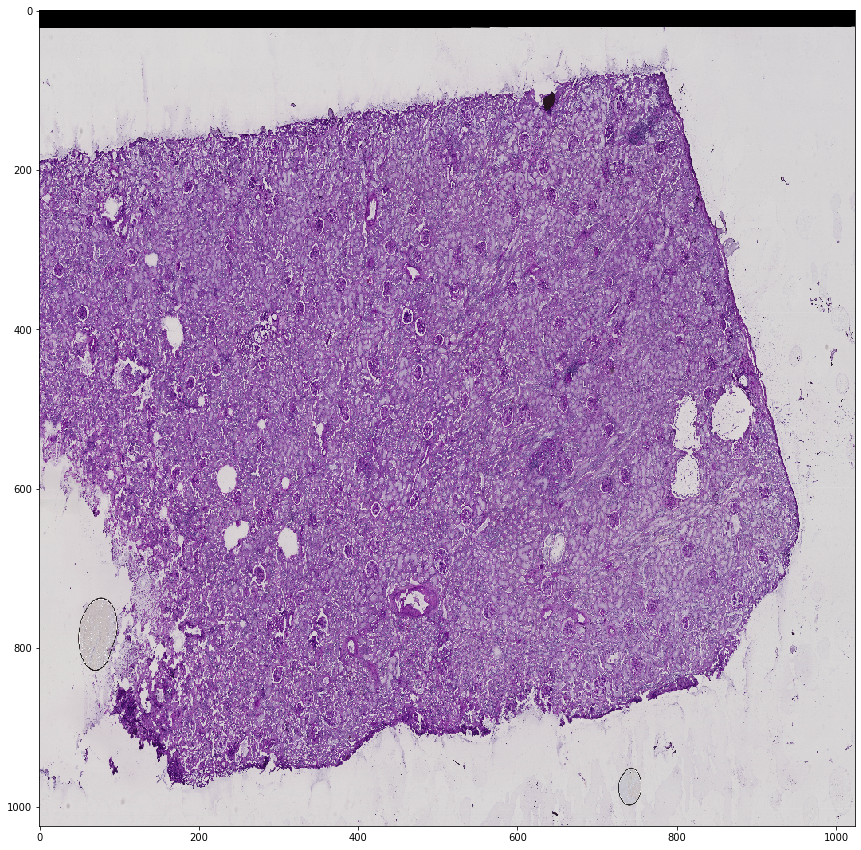

In [6]:
image_re = cv2.resize(image, (1024, 1024))
plt.figure(figsize=(15,15))
plt.imshow(image_re)

In [7]:
_id = "aaa6a05cc"
image, mask = get_image_mask(_id)
print(_id, image.shape, mask.shape)

need_shift = {
    "e79de561c":[10, 5],
    "095bf7a1f":[20, 15],
    "54f2eec69":[-10, -15]
}
if _id in need_shift:
    print(_id, "需要修正mask")
    shift_horizontal, shift_vertical = need_shift[_id]
    h, w = mask.shape
    mask_temp = np.zeros_like(mask)
    mask_temp[max(0, -shift_vertical):min(h, h-shift_vertical), max(0, -shift_horizontal):min(w, w-shift_horizontal)] = \
        mask[max(0, shift_vertical):min(h, h+shift_vertical), max(0, shift_horizontal):min(w, w+shift_horizontal)]
    mask = mask_temp.copy()
    del mask_temp

mask_re = cv2.resize(mask, (1024, 1024))
label_img = label(mask_re, connectivity = mask.ndim)
props = regionprops(label_img)
print("mask数量", len(props))

window_size = 0
for p in props:
    bbox = list(p.bbox)
    bbox[0] = int(bbox[0]* mask.shape[0]/1024)
    bbox[2] = int(bbox[2]* mask.shape[0]/1024)
    bbox[1] = int(bbox[1]* mask.shape[1]/1024)
    bbox[3] = int(bbox[3] * mask.shape[1]/1024)
    window_size += 3*(((bbox[2]-bbox[0]) + (bbox[3]-bbox[1]))/2)
    
    random_scalors = [1.5, 5, 10]
    for random_scalor in random_scalors:
        margin = int(((bbox[2]-bbox[0]) + (bbox[3]-bbox[1]))//random_scalor)  
        cv2.imwrite(img_root + "{}_img.png".format(data_count), image[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin])
        cv2.imwrite(mask_root + "{}_mask.png".format(data_count), mask[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin])
        data_count += 1

window_size = int(window_size/len(props))
mesh_grid = make_grid(image.shape[:2], window=window_size, min_overlap = int(window_size//4))

mask = mask*255
for cell in mesh_grid:
    cv2.imwrite(img_root + "{}_img.png".format(data_count), image[cell[0]:cell[1], cell[2]:cell[3]])
    cv2.imwrite(mask_root + "{}_mask.png".format(data_count), mask[cell[0]:cell[1], cell[2]:cell[3]])
    data_count += 1

aaa6a05cc (18484, 13013, 3) (18484, 13013)
mask数量 93


In [21]:
for p in props:
    bbox = list(p.bbox)
    bbox[0] = int(bbox[0]* mask.shape[0]/1024)
    bbox[2] = int(bbox[2]* mask.shape[0]/1024)
    bbox[1] = int(bbox[1]* mask.shape[1]/1024)
    bbox[3] = int(bbox[3] * mask.shape[1]/1024)
    
#     maxf, minf = 10, 1.5
#     random_scalors = (maxf - minf)*np.random.random_sample(4)+minf
    random_scalors = [1.5, 5, 10]
    for random_scalor in random_scalors:
        margin = int(((bbox[2]-bbox[0]) + (bbox[3]-bbox[1]))//random_scalor)  
        cv2.imwrite(img_root + "{}_img.png".format(data_count), image[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin])
        cv2.imwrite(mask_root + "{}_mask.png".format(data_count), mask[bbox[0]-margin:bbox[2]+margin, bbox[1]-margin:bbox[3]+margin])
        data_count += 1
    
    

In [26]:
maxf, minf = margin*2, -margin*2
random_shift = (maxf - minf)*np.random.random_sample(2)+minf
print(random_shift)

[-54.35869589 -65.82023272]


In [23]:
margin

36

In [11]:
np.random.rand

In [20]:
window_size = 0
for p in props:
    bbox = list(p.bbox)
    bbox[0] = int(bbox[0]* mask.shape[0]/1024)
    bbox[2] = int(bbox[2]* mask.shape[0]/1024)
    bbox[1] = int(bbox[1]* mask.shape[1]/1024)
    bbox[3] = int(bbox[3] * mask.shape[1]/1024)
    window_size += 3*(((bbox[2]-bbox[0]) + (bbox[3]-bbox[1]))/2)
window_size = int(window_size/len(props))

In [21]:
window_size

746

In [18]:
(bbox[2]-bbox[0]) + (bbox[3]-bbox[1])

24

In [22]:
bbox

[15523, 4473, 15740, 4625]